# Semantic chunk score exploration

Now that we have some of the semantic chunk data scored for perplexity ratio, let's take a look and see what we are working with.

## Notebook setup

In [1]:
# Change working directory to parent so we can import as we would from the perplexity ratio score root directory
%cd ..

# PyPI imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from statistics import mean
from scipy.stats import ttest_ind

# Internal imports
import configuration as config
import notebooks.helper_functions.plotting_functions as plot_funcs

/home/siderealyear/projects/llm_detector/perplexity_ratio_score


## 1. Data loading

In [12]:
data_file=f'{config.SCORED_DATA_PATH}/test_chunks.47.parquet'
data_df=pd.read_parquet(data_file)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 579834 entries, 0 to 579833
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Text                    579834 non-null  object 
 1   Synthetic               579834 non-null  int64  
 2   Author                  579834 non-null  object 
 3   Source                  579834 non-null  object 
 4   Perplexity ratio score  579834 non-null  float64
 5   Cross-perplexity        579834 non-null  float64
 6   Perplexity              579834 non-null  float64
 7   Text length (words)     579834 non-null  int64  
 8   Text length (tokens)    579834 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 39.8+ MB


## 2. Data cleaning

In [13]:
# Check for NANs
print(f'{len(data_df)} total rows\n')
data_df.isna().sum()

579834 total rows



Text                      0
Synthetic                 0
Author                    0
Source                    0
Perplexity ratio score    0
Cross-perplexity          0
Perplexity                0
Text length (words)       0
Text length (tokens)      0
dtype: int64

In [14]:
# And remove them
data_df.dropna(inplace=True)

# Check the result
print(f'{len(data_df)} total rows\n')
data_df.isna().sum()

579834 total rows



Text                      0
Synthetic                 0
Author                    0
Source                    0
Perplexity ratio score    0
Cross-perplexity          0
Perplexity                0
Text length (words)       0
Text length (tokens)      0
dtype: int64

In [15]:
# Remove any duplicate rows
data_df.drop_duplicates(inplace=True)

# Check the result
print(f'{len(data_df)} total rows')

579834 total rows


In [16]:
# Save the cleaned data
data_df.to_parquet(data_file)

## 3. Data composition

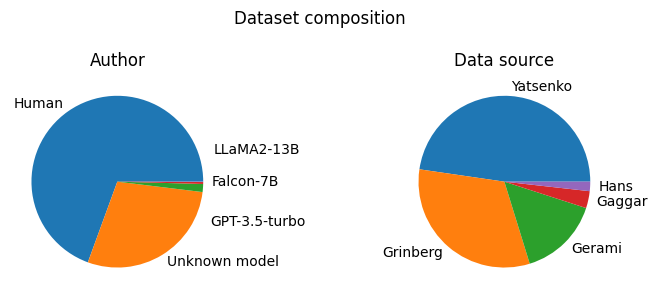

In [17]:
plot_obj=plot_funcs.data_composition(data_df)
plot_obj.savefig(f'{config.PLOT_PATH}/07-2_data_composition.jpg')
plot_obj.show()

## 4. Text length

In [18]:
data_df['Text length (words)'].describe()

count    579834.000000
mean         28.781513
std          47.255698
min           1.000000
25%          10.000000
50%          15.000000
75%          26.000000
max         455.000000
Name: Text length (words), dtype: float64

### 4.1. Length distributions: all text

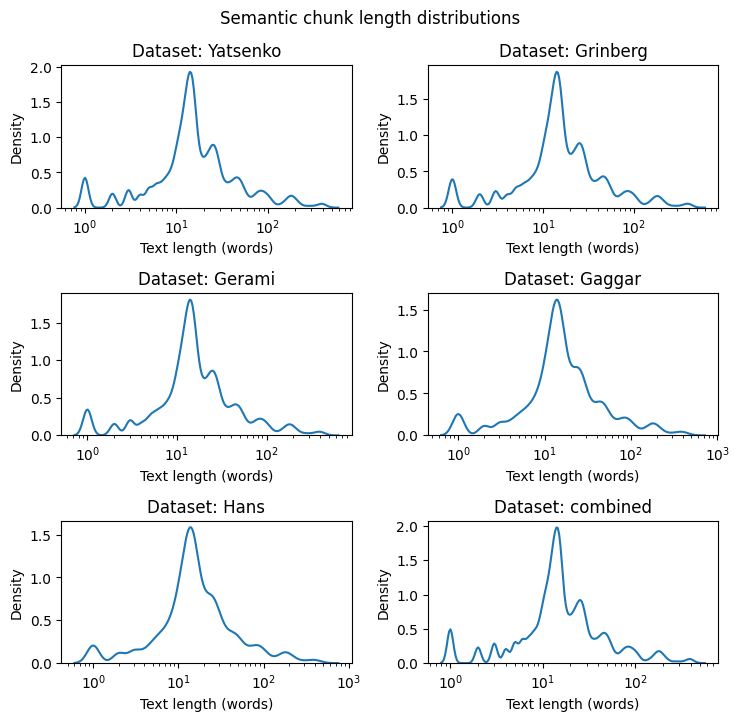

In [19]:
plot_obj=plot_funcs.length_distributions('Semantic chunk length distributions', data_df)
plot_obj.savefig(f'{config.PLOT_PATH}/07-4.1_semantic_chunk_length_distributions.jpg')
plot_obj.show()

Just for fun, let's take a look at the chunk length distributions for human vs machine text. But before we do - let's provisionally get rid of any single word chunks - we can pretty clearly justify that as a splitting failure, if nothing else. Let's also trim off very long chunks.

### 4.2. Length distributions: human vs synthetic

In [20]:
# Length threshold the data
working_data_df=data_df[data_df['Text length (words)'] > 1]
working_data_df=working_data_df[working_data_df['Text length (words)'] < 1024]

# Replace int values for 'synthetic' with human readable strings
working_data_df['Synthetic']=working_data_df['Synthetic'].map({0: 'Human', 1: 'Synthetic'})
working_data_df.head()

,Text,Synthetic,Author,Source,Perplexity ratio score,Cross-perplexity,Perplexity,Text length (words),Text length (tokens)
0,Among the problems that occurred on that eve i...,Human,Human,Grinberg,0.773038,4.578125,3.540,18,20
1,TKT children will start to think it is okay to...,Human,Human,Gerami,1.096833,4.316406,4.734,18,20
2,"Cultural disposition, according to Campbell & ...",Human,Human,Yatsenko,0.999434,3.451172,3.450,18,20
3,According to Barack and Clow (9) advertising h...,Human,Human,Grinberg,1.169778,3.347656,3.916,18,20
4,The Allure of Hacking,Human,Human,Grinberg,0.738267,5.410156,3.994,18,20


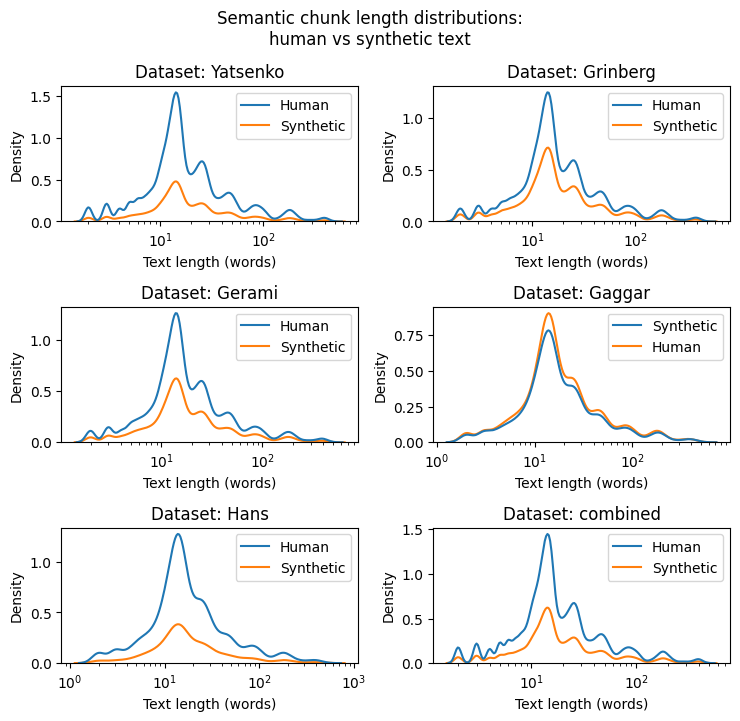

In [21]:
plot_obj=plot_funcs.length_distributions(
    'Semantic chunk length distributions:\nhuman vs synthetic text',
    working_data_df, 
    hue_by='Synthetic'
)

plot_obj.savefig(f'{config.PLOT_PATH}/07-4.2_human_vs_synthetic_length_distributions.jpg')
plot_obj.show()

Both distributions plots look qualitatively similar to those generated from the complete dataset prior to scoring. Let's move on and look at the perplexity ratio score.

## 5. Perplexity ratio score

### 5.1. Human vs synthetic mean by dataset source

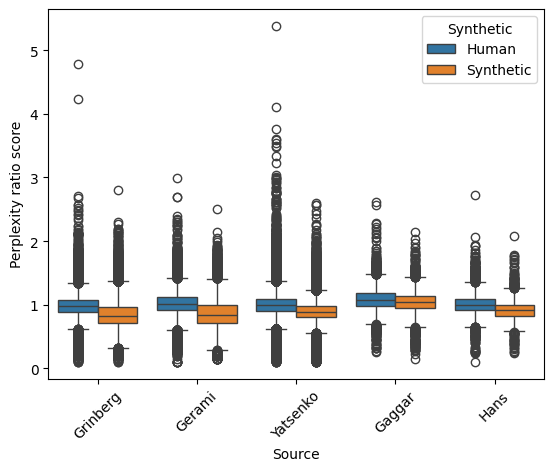

In [22]:
ax=sns.boxplot(data=working_data_df, x='Source', y='Perplexity ratio score', hue='Synthetic')
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(f'{config.PLOT_PATH}/07-5.1_perplexity_ratio_score_mean_by_dataset_source.jpg')
plt.show()

OK - cool! Looks qualitatively similar to the original Hans dataset by itself. Means are pretty clearly different, but there is a lot of overlap between the distributions. 

It's interesting that the Gaggar dataset seems the least differentiated and scores highest overall. That dataset contains GPT-3.5-turbo output, which is the most powerful adversary model in the dataset. But, the data was also created by prompting the model to rephrase human written text. This is different than purely generated responses.

Let's do a t-test and set-up a confidence interval around the difference in means to find out a little more quantitatively how different the two distributions actually are.

### 5.2. Human vs synthetic mean by author

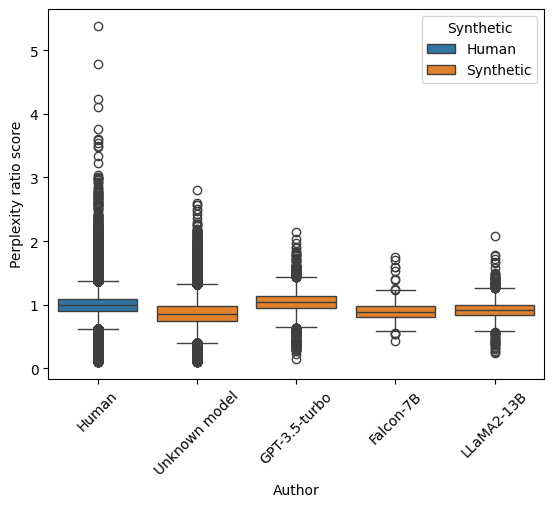

In [23]:
ax=sns.boxplot(data=working_data_df, x='Author', y='Perplexity ratio score', hue='Synthetic')
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(f'{config.PLOT_PATH}/07-5.2_perplexity_ratio_score_mean_by_author.jpg')
plt.show()

Same observations as above apply. Perplexity score mean is lower for synthetic text on average. The only model the output of which we are not convincingly detecting in aggregate is GPT-3.5-turbo, but again this is a 'rephrasing' dataset, not a *de novo* machine generated text dataset.

The only real solution to that kind of nit-picking is to synthesize our own data using a selection of different models. Problem will be the cost of using proprietary APIs to do so. No one is gonna take us seriously if we can't detect the newest, fanciest chatGPT.

For now, we can just exclude the Gagger data on the basis of how it was generated if it drags the dataset wide accuracy down too much.

In [24]:
# Split the data into human and synthetic
human_df=working_data_df[working_data_df['Synthetic'] == 'Human']
synthetic_df=working_data_df[working_data_df['Synthetic'] == 'Synthetic']

# Pull the data for this model
human=human_df['Perplexity ratio score']
synthetic=synthetic_df['Perplexity ratio score']

# Get the means in question and their difference
human_mean=mean(human)
synthetic_mean=mean(synthetic)
mean_diff=human_mean - synthetic_mean

# Get the confidence interval
cm=sms.CompareMeans(sms.DescrStatsW(human), sms.DescrStatsW(synthetic))
difference=cm.tconfint_diff(usevar='unequal')
low_bound=difference[0]
high_bound=difference[1]

# Do a t-test with H0 equal means, H1 human greater than synthetic
ttest_result = ttest_ind(human, synthetic, alternative='greater')

print(f'T-test p-value = {ttest_result.pvalue}')
print(f'Difference in means = {mean_diff:.3f}, 95% CI = ({low_bound:.3f}, {high_bound:.3f})')

T-test p-value = 0.0
Difference in means = 0.119, 95% CI = (0.118, 0.120)


Good, marginally better even. Just for reference - here is the Falcon-7B reader/writer result for the old Hans only dataset:

```
Model: Falcon-7B, t-test p-value = 1.468072030319169e-94
Model: Falcon-7B, difference in means = 0.116, 95% CI = (0.106, 0.126)
```

### 5.3. Human vs synthetic distribution

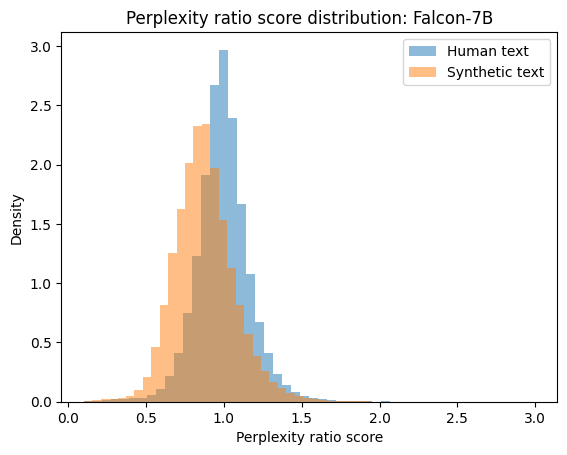

In [25]:
# Threshold the data for plotting
human_df=human_df[human_df['Perplexity ratio score'] < 3]
synthetic_df=synthetic_df[synthetic_df['Perplexity ratio score'] < 3]

plt.title('Perplexity ratio score distribution: Falcon-7B')
plt.hist(human_df['Perplexity ratio score'], density=True, label='Human text', bins=50, alpha=0.5)
plt.hist(synthetic_df['Perplexity ratio score'], density=True, label='Synthetic text', bins=50, alpha=0.5)
plt.xlabel('Perplexity ratio score')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.savefig(f'{config.PLOT_PATH}/07-5.3_perplexity_ratio_score_distribution.jpg')
plt.show()

### 5.4. Perplexity ratio score by text length

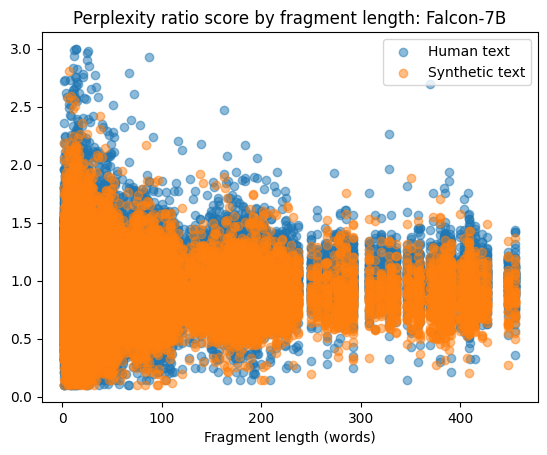

In [26]:
plt.title('Perplexity ratio score by fragment length: Falcon-7B')
plt.scatter(human_df['Text length (words)'], human_df['Perplexity ratio score'], alpha=0.5, label='Human text')
plt.scatter(synthetic_df['Text length (words)'], synthetic_df['Perplexity ratio score'], alpha=0.5, label='Synthetic text')
plt.xlabel('Fragment length (words)')
plt.legend(loc='upper right')
plt.savefig(f'{config.PLOT_PATH}/07-5.4_perplexity_ratio_score_by_text_length.jpg')
plt.show()

Also, on the whole, very similar to the Hans data alone. Even if the fact that the gagger synthetic GPT data seems to score similarly to human is slightly concerning, it's good news that overall our trick seems to work well on data from other sources.